In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%%time
# Load data #
mergeddata=pd.read_csv("merged.csv")

#  Print columns of dataset with missing values #
list = mergeddata.columns[mergeddata.isna().any()].tolist()
print(list)

# Fill NA values with mean of the corresponding column #
for i in list:
    print(i)
    print(mergeddata.isna().sum())                      
    mergeddata[i].fillna(mergeddata[i].mean(), inplace=True)  

[]
CPU times: total: 15.6 ms
Wall time: 14.1 ms


In [3]:
# Separate features and target
features = mergeddata.iloc[:, :-1]  # All columns except the last one
target = mergeddata.iloc[:, -1]     # The last column
print(features.head(n=10))
print(target.head(n=10))

# Train test split and scale data #
X1,X2,y1,y2 =train_test_split(features, target, stratify=target, test_size= 0.30, random_state=1000) # repeat for all five seeds in seedlist = [453, 560, 793, 972, 1000], for five model evaluation rounds
scaler = StandardScaler()
x1 = pd.DataFrame(scaler.fit_transform(X1))                
x2 = pd.DataFrame(scaler.transform(X2))
#print(x1.shape, x2.shape, y1.shape, y2.shape)
#print(x1.head(n=5),y1.head(n=5))
#print(x2.head(n=5),y2.head(n=5))

# To perform cross validation on train set #
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  

    83-148   83-149   83-150  123-299  161-176  168-297  172-174  256-291  \
0  6.98172  8.03743  8.49984  4.84695  4.78105  5.04026  4.63637  14.2376   
1  7.91593  8.46268  9.79619  5.72662  4.99733  5.13205  4.36940  15.1991   
2  3.19709  4.14582  5.59771  4.29520  4.94506  5.21529  5.01088  14.4558   
3  4.92428  2.19683  5.15414  5.15719  4.69634  5.01173  5.00048  14.3499   
4  3.36984  3.98278  5.10306  3.88632  5.00283  5.11213  4.98825  14.5466   
5  3.76155  4.44284  6.12459  4.90722  4.91182  5.37944  4.73117  13.8447   
6  5.76129  5.94946  7.25685  3.98009  4.72784  5.06096  5.00465  15.0830   
7  5.84664  5.19958  6.69821  3.70781  5.03388  5.10414  5.24649  15.4749   
8  2.59488  3.84461  5.27231  3.63808  4.57957  5.17273  5.16674  14.6314   
9  2.54641  4.31167  6.06185  5.17188  5.19962  4.58905  5.25533  15.7994   

   301-303    47-74  ...  215-259  232-238  259-283  297-299    32-55  \
0  5.40775  5.61842  ...  2.90620  5.11529  2.26574  2.96213  4.96796   
1  4.9

In [4]:
# BASE MODEL evaluation #
XG = XGBClassifier(random_state=42, n_jobs=-1)
base_model = XG 

accuracy_scores = []
f1_scores = []
precision_scores = []
recall_scores = []
specificity_scores = []

# Model evaluation for cross validation on TRAINING DATASET #

for train_index, test_index in cv.split(x1,y1):
    #print(len(train_index))
    #print(len(test_index))
    X_train, X_test = x1.iloc[train_index], x1.iloc[test_index]
    y_train, y_test = y1.iloc[train_index], y1.iloc[test_index]
    base_model.fit(X_train, y_train)
    y_pred = base_model.predict(X_test)
    
    cm = confusion_matrix(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    specificity = cm[0,0]/(cm[0,0]+cm[0,1])
    
    accuracy_scores.append(acc)
    f1_scores.append(f1)
    precision_scores.append(precision)
    recall_scores.append(recall)
    specificity_scores.append(specificity)
    
avg_acc=np.mean(accuracy_scores)
avg_f1=np.mean(f1_scores)
avg_precision=np.mean(precision_scores)
avg_recall=np.mean(recall_scores)
avg_specificity=np.mean(specificity_scores)

scoredata = pd.DataFrame()
valscoredict = pd.DataFrame({'Data':'Validation','score_accuracy':avg_acc,'score_f1':avg_f1,'score_precision':avg_precision,'score_recall':avg_recall, 'score_specificity': avg_specificity}, index=[0])
scoredata=pd.concat([scoredata, valscoredict], axis=0)
print(scoredata)

# Model evaluation on TEST DATASET #

base_model.fit(x1, y1)
y2_base_predict = pd.Series(base_model.predict(x2))

base_test_accuracy = accuracy_score(y2, y2_base_predict)
base_test_f1 = f1_score(y2, y2_base_predict)
base_test_precision = precision_score(y2, y2_base_predict)
base_test_recall = recall_score(y2, y2_base_predict)
base_test_specificity = cm[0,0]/(cm[0,0]+cm[0,1])

testscoredict = pd.DataFrame({'Data':'Test','score_accuracy':base_test_accuracy,'score_f1':base_test_f1,'score_precision':base_test_precision,'score_recall':base_test_recall, 'score_specificity': base_test_specificity},index=[0])
scoredata=pd.concat([scoredata, testscoredict], axis=0)
print(scoredata)

         Data  score_accuracy  score_f1  score_precision  score_recall  \
0  Validation        0.933333  0.933333              0.9           1.0   

   score_specificity  
0                0.9  
         Data  score_accuracy  score_f1  score_precision  score_recall  \
0  Validation        0.933333  0.933333         0.900000      1.000000   
0        Test        0.333333  0.333333         0.333333      0.333333   

   score_specificity  
0                0.9  
0                1.0  


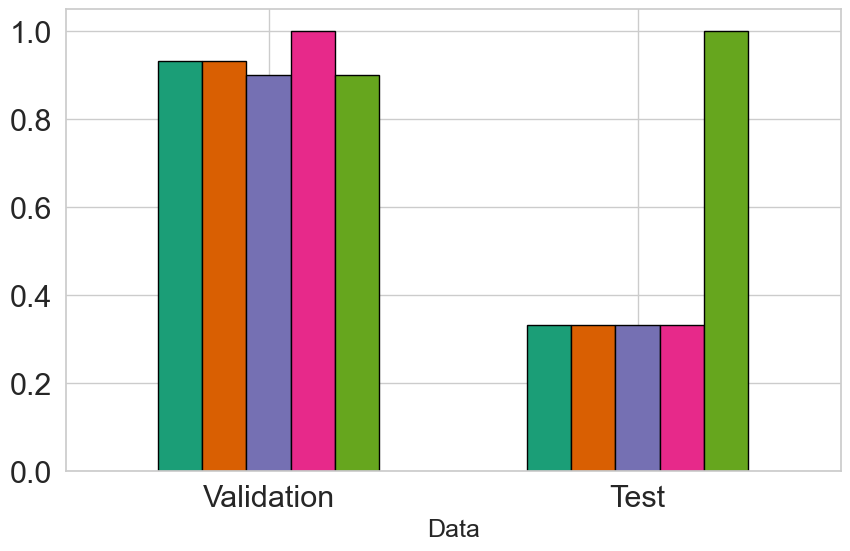

In [5]:
## PLOTS for BASE MODEL ##
sns.set(font_scale = 1.5)
sns.set_style("whitegrid")

# Plot classification scores #
c = plt.get_cmap('Dark2')
scoredata.plot.bar(x="Data", rot=0, width=0.6, figsize=(10,6), fontsize=22, legend=False, edgecolor="black", linewidth=1, color = c.colors)
plt.savefig("XGBoutputs/XGB-barplot-seed1000.png", dpi=300)
plt.show()

83-149     1.0
89-141     0.0
154-161    0.0
131-256    0.0
124-300    0.0
          ... 
208-276    0.0
208-277    0.0
259-291    0.0
262-287    0.0
195-228    0.0
Name: Importance, Length: 66, dtype: float32
         Importance  Cumulative
83-149          1.0         1.0
89-141          0.0         1.0
154-161         0.0         1.0
131-256         0.0         1.0
124-300         0.0         1.0
...             ...         ...
208-276         0.0         1.0
208-277         0.0         1.0
259-291         0.0         1.0
262-287         0.0         1.0
195-228         0.0         1.0

[66 rows x 2 columns]


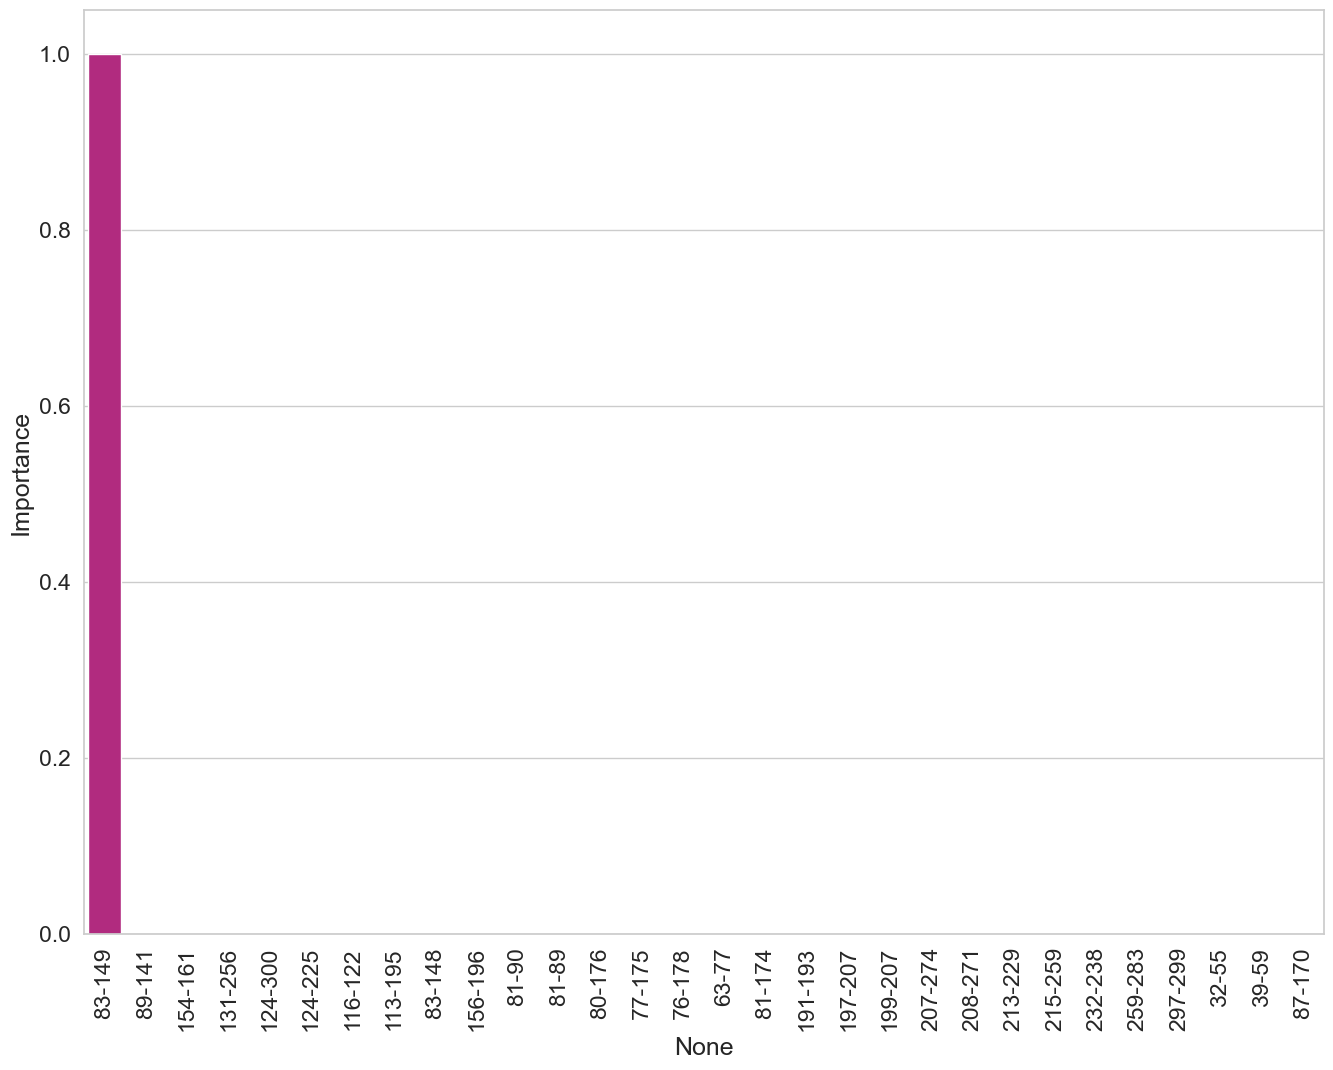

In [6]:
# Extract feature importance #
feature_imp = pd.Series(base_model.feature_importances_, index=features.columns, name='Importance').sort_values(ascending=False)
imp = feature_imp
print(imp)

cumsum = pd.Series(imp.cumsum(),name='Cumulative')
mergedscore = pd.DataFrame(pd.concat([feature_imp, cumsum], axis=1))
mergedscore.to_csv("XGBoutputs/XGB-seed1000.csv", sep=",")

# Filter features which contribute to 99% total importance of classification #
#filt = (mergedscore['Cumulative'] < 0.99) 
#df1 = mergedscore[filt]
df1 = mergedscore
print(df1)

# Feature Importance Plot #
plt.figure(figsize=(16,12))
topf=df1.iloc[:30]
sns.barplot(x=topf.index, y=topf['Importance'], data=topf, color="mediumvioletred")
plt.xticks(rotation='vertical')
plt.savefig("XGBoutputs/XGB-featureimp-seed1000.png", dpi=300)
plt.show()